In [64]:
import pandas as pd
import numpy as np

data_path = "data/"

In [65]:
df = pd.read_csv(data_path + "time_series_data.csv")
df_train = df[df["Year"] <= 2023]
df_test = df[df["Year"] > 2023]
"num_days" in df_train.columns

True

In [66]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [67]:
categorical_cols = ["location_name"]
numerical_cols = ["sin_month", "cos_month", "Year", "Month", "num_days", "holiday_num"]
numerical_features = [
    "crime_count",
    "crime_pct_change",
    "morning",
    "afternoon",
    "evening",
    "night",
    "domestic",
    "arrest",
]
for i in [1, 2, 3, 6, 12]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_lag{i}")
for i in [3, 6]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_ma{i}")

# Split features and target
X_train = df_train[categorical_cols + numerical_cols]
y_train = df_train["crime_count"]
X_test = df_test[categorical_cols + numerical_cols]
y_test = df_test["crime_count"]

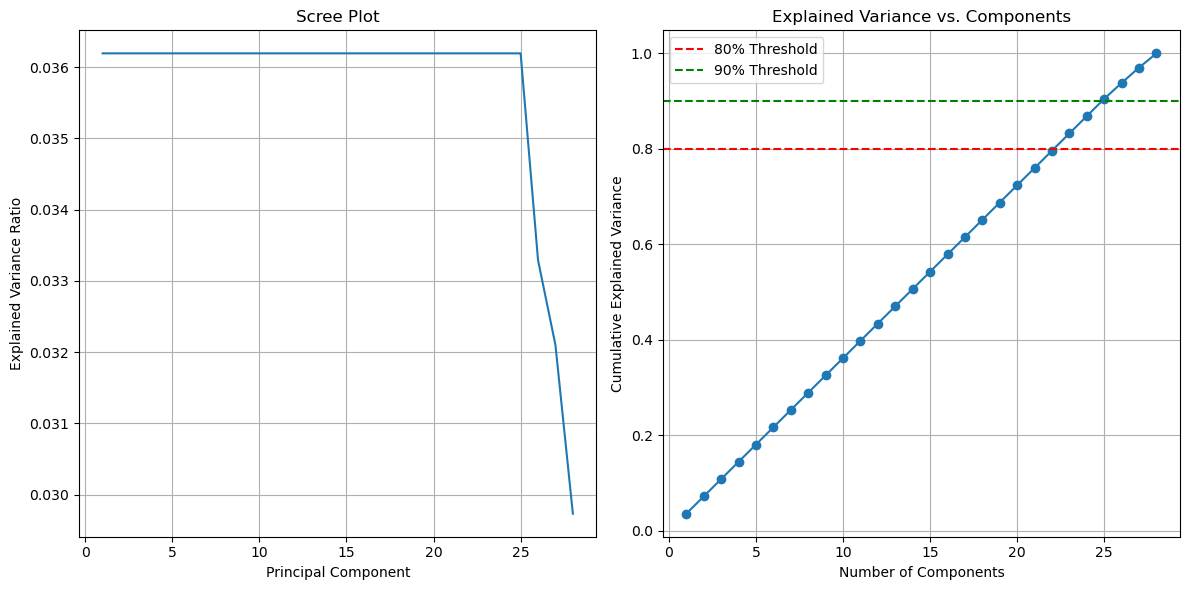

In [68]:
from sklearn.decomposition import PCA

ohc = OneHotEncoder(handle_unknown="ignore")
X_coded = ohc.fit_transform(X_train[categorical_cols])
pca = PCA(n_components=X_coded.shape[1] - 1, random_state=42)
pca_result = pca.fit_transform(X_coded)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)

# Plot the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Components")
plt.axhline(y=0.8, color="r", linestyle="--", label="80% Threshold")
plt.axhline(y=0.9, color="g", linestyle="--", label="90% Threshold")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
cat_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat_pipe", cat_pipe, categorical_cols),
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())],
)

In [70]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['sin_month', 'cos_month',
                                                   'Year', 'Month', 'num_days',
                                                   'holiday_num',
                                                   'crime_count_lag1',
                                                   'crime_pct_change_lag1',
                                                   'morning_lag1',
                                                   'afternoon_lag1',
                                                   'evening_lag1', 'night_lag1',
                                                   'domestic_lag1',
                                                   'arrest_lag1',
                                                   'crime_count_lag2',
                                                   'crime_pct_change_lag2',
                                                   'morning_lag2',
                                                   'afternoon_lag2',
                                                   'evening_lag2', 'night_lag2',
                                                   'domestic_lag2',
                                                   'arrest_lag2',
                                                   'crime_count_lag3',
                                                   'crime_pct_change_lag3',
                                                   'morning_lag3',
                                                   'afternoon_lag3',
                                                   'evening_lag3', 'night_lag3',
                                                   'domestic_lag3',
                                                   'arrest_lag3', ...]),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['location_name'])])),
                ('regressor', LinearRegression())])

In [71]:
lr_train_pred = model.predict(X_train)
lr_pred = model.predict(X_test)
lr_train_pred = np.round(lr_train_pred)
lr_pred = np.round(lr_pred)

In [72]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Calculate regression metrics
rmse = root_mean_squared_error(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)
mean_value = y_test.mean()
print(mean_value)
mae_percentage = (mae / mean_value) * 100

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {mae_percentage:.2f}%")

743.8265895953757
Root Mean Squared Error: 132.99
Mean Absolute Error: 56.13
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 7.55%


# Random Forest Regressor


In [73]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [74]:
from sklearn.ensemble import RandomForestRegressor

# Same preprocessing pipeline, but switch out the regressor
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_pred = rf_model.predict(X_test)
rf_train_pred = np.round(rf_train_pred)
rf_pred = np.round(rf_pred)

In [75]:
# Evaluate the model
rf_rmse = root_mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae_percentage = (rf_mae / y_test.mean()) * 100

print(f"Random Forest Results:")
print(f"Root Mean Squared Error: {rf_rmse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {rf_mae_percentage:.2f}%")

Random Forest Results:
Root Mean Squared Error: 157.01
Mean Absolute Error: 53.29
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 7.16%


In [76]:
from xgboost import XGBRegressor

xg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        (
            "regressor",
            XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=7,
                gamma=0.1,
                random_state=42,
            ),
        ),
    ]
)
xg_model.fit(X_train, y_train)
xg_train_pred = xg_model.predict(X_train)
xg_pred = xg_model.predict(X_test)
xg_train_pred = np.round(xg_train_pred)
xg_pred = np.round(xg_pred)

In [77]:
# Evaluate the model
xg_rmse = root_mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_r2 = r2_score(y_test, xg_pred)
xg_mae_percentage = (xg_mae / y_test.mean()) * 100
print(f"XGBoost Results:")
print(f"Root Mean Squared Error: {xg_rmse:.2f}")
print(f"Mean Absolute Error: {xg_mae:.2f}")
print(f"R² Score: {xg_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {xg_mae_percentage:.2f}%")

XGBoost Results:
Root Mean Squared Error: 139.71
Mean Absolute Error: 50.88
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 6.84%


In [78]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    "regressor__n_estimators": [200],
    "regressor__learning_rate": [0.1],
    "regressor__max_depth": [5],
    "regressor__min_child_weight": [5],
    "regressor__gamma": [0.1],
}

# Create the pipeline with XGBRegressor
xg_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=42))]
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Display progress
)

# Fit the grid search to the data
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best parameters: {best_params}")

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Training metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Testing metrics
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing R²: {test_r2:.4f}")

# Store residuals for plotting
xg_res = y_test - y_test_pred

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Grid search completed!
Best parameters: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 200}

Model Performance:
Training RMSE: 12.7458
Training R²: 1.0000
Testing RMSE: 127.1771
Testing R²: 0.9954


In [79]:
df_train_result = df_train.copy()
df_test_result = df_test.copy()
df_lstm = pd.read_csv(data_path + "lstm_predictions.csv")
df_lstm[["location_id", "crime_count", "lstm_pred", "time_id"]]
df_train_lstm = df_lstm[df_lstm["Year"] <= 2023]
df_test_lstm = df_lstm[df_lstm["Year"] > 2023]
df_train_result = df_train_result.merge(
    df_train_lstm[["location_id", "time_id", "lstm_pred"]],
    on=["location_id", "time_id"],
    how="left",
)
df_test_result = df_test_result.merge(
    df_test_lstm[["location_id", "time_id", "lstm_pred"]],
    on=["location_id", "time_id"],
    how="left",
)
df_train_result["lr_pred"] = lr_train_pred
df_train_result["rf_pred"] = rf_train_pred
df_train_result["xg_pred"] = xg_train_pred
df_test_result["lr_pred"] = lr_pred
df_test_result["rf_pred"] = rf_pred
df_test_result["xg_pred"] = xg_pred
df_train_result["lstm_pred"] = df_train_result["lstm_pred"]
df_test_result["lstm_pred"] = df_test_result["lstm_pred"]


# Add residuals (actual - predicted)
df_train_result["lr_res"] = df_train_result["crime_count"] - df_train_result["lr_pred"]
df_train_result["rf_res"] = df_train_result["crime_count"] - df_train_result["rf_pred"]
df_train_result["xg_res"] = df_train_result["crime_count"] - df_train_result["xg_pred"]
df_train_result["lstm_res"] = (
    df_train_result["crime_count"] - df_train_result["lstm_pred"]
)
df_test_result["lr_res"] = df_test_result["crime_count"] - df_test_result["lr_pred"]
df_test_result["rf_res"] = df_test_result["crime_count"] - df_test_result["rf_pred"]
df_test_result["xg_res"] = df_test_result["crime_count"] - df_test_result["xg_pred"]
df_test_result["lstm_res"] = df_test_result["crime_count"] - df_test_result["lstm_pred"]
df_test_result[
    ["time_id", "location_id", "crime_count", "xg_pred", "lr_pred", "rf_pred"]
]
df_train_result

,location_name,location_id,Year,Month,crime_count,arrest,domestic,weekday,weekend,morning,...,evening_ma6,night_ma6,lstm_pred,lr_pred,rf_pred,xg_pred,lr_res,rf_res,xg_res,lstm_res
0,Abandoned/Condemned Structure,1,2019,1,27,15,0,24,3,16,...,4.333333,3.833333,20.0,38.0,25.0,23.0,-11.0,2.0,4.0,7.0
1,Air/Bus/Train Terminal,2,2019,1,615,148,11,482,133,125,...,125.333333,108.666667,589.0,576.0,594.0,594.0,39.0,21.0,21.0,26.0
2,Arena/Stadium/Fairgrounds/Coliseum,4,2019,1,30,3,0,19,11,5,...,18.666667,4.666667,37.0,47.0,33.0,39.0,-17.0,-3.0,-9.0,-7.0
3,ATM Separate from Bank,5,2019,1,25,2,0,21,4,9,...,4.666667,8.166667,29.0,53.0,23.0,21.0,-28.0,2.0,4.0,-4.0
4,Auto Dealership New/Used,6,2019,1,18,1,2,15,3,8,...,5.666667,4.500000,20.0,57.0,18.0,17.0,-39.0,0.0,1.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,Restaurant,37,2023,12,508,48,23,306,202,80,...,107.166667,99.666667,477.0,497.0,491.0,513.0,11.0,17.0,-5.0,31.0
1713,School/College,38,2023,12,331,18,14,314,17,141,...,14.000000,16.500000,373.0,334.0,379.0,355.0,-3.0,-48.0,-24.0,-42.0
1714,Service/Gas Station,41,2023,12,243,40,7,162,81,63,...,71.833333,88.166667,244.0,240.0,245.0,244.0,3.0,-2.0,-1.0,-1.0
1715,Other/Unknown,98,2023,12,1555,187,87,1065,490,405,...,312.166667,245.833333,1546.0,1518.0,1535.0,1520.0,37.0,20.0,35.0,9.0


In [80]:
# summarize the results (metrics)
def summarize_results(df, model):
    rmse = root_mean_squared_error(df["crime_count"], df[model])
    mae = mean_absolute_error(df["crime_count"], df[model])
    r2 = r2_score(df["crime_count"], df[model])
    mean_value = df["crime_count"].mean()
    mae_percentage = (mae / mean_value) * 100
    return rmse, mae, r2, mae_percentage


for m in ["lr", "rf", "xg", "lstm"]:
    rmse, mae, r2, mae_percentage = summarize_results(df_test_result, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

Model: lr
RMSE	R²	MAE	MAE Percentage
132.99	0.99	56.13	7.55%


Model: rf
RMSE	R²	MAE	MAE Percentage
157.01	0.99	53.29	7.16%


Model: xg
RMSE	R²	MAE	MAE Percentage
139.71	0.99	50.88	6.84%


Model: lstm
RMSE	R²	MAE	MAE Percentage
137.48	0.99	47.70	6.41%




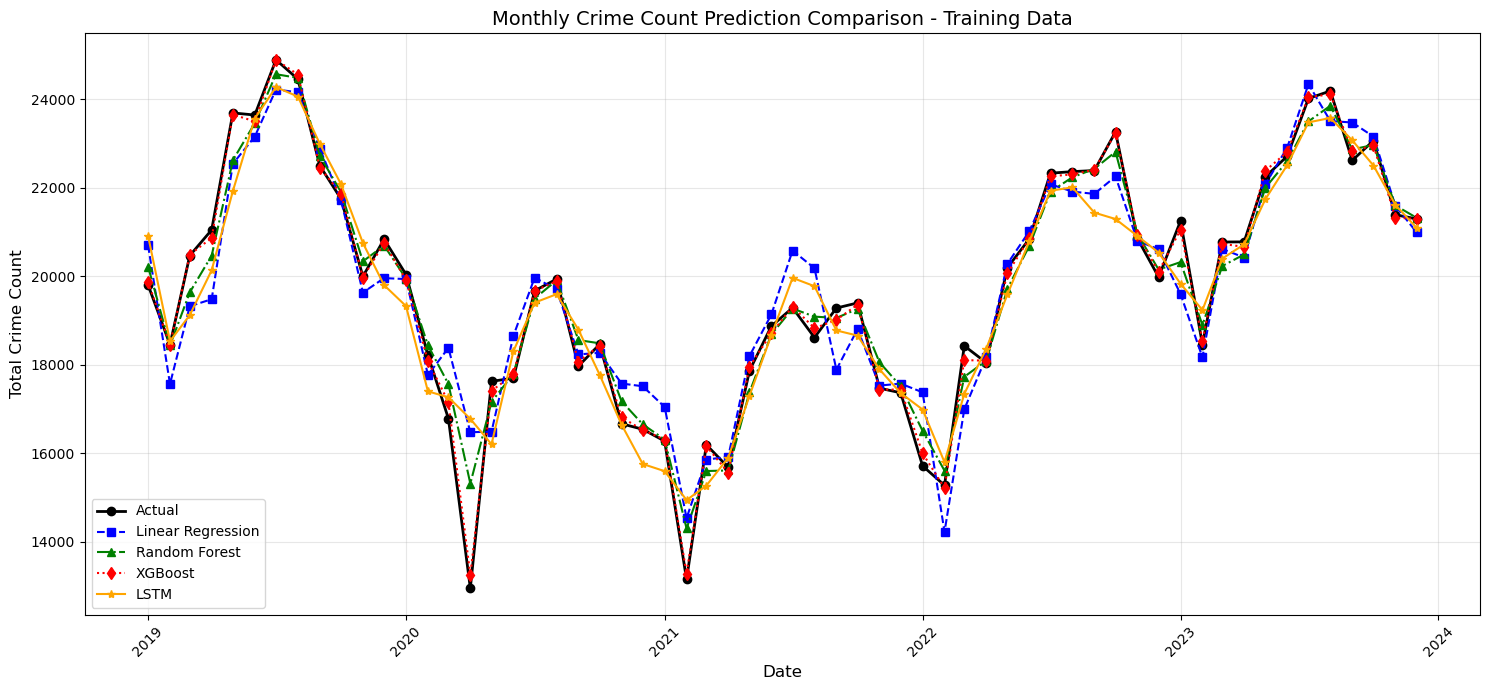

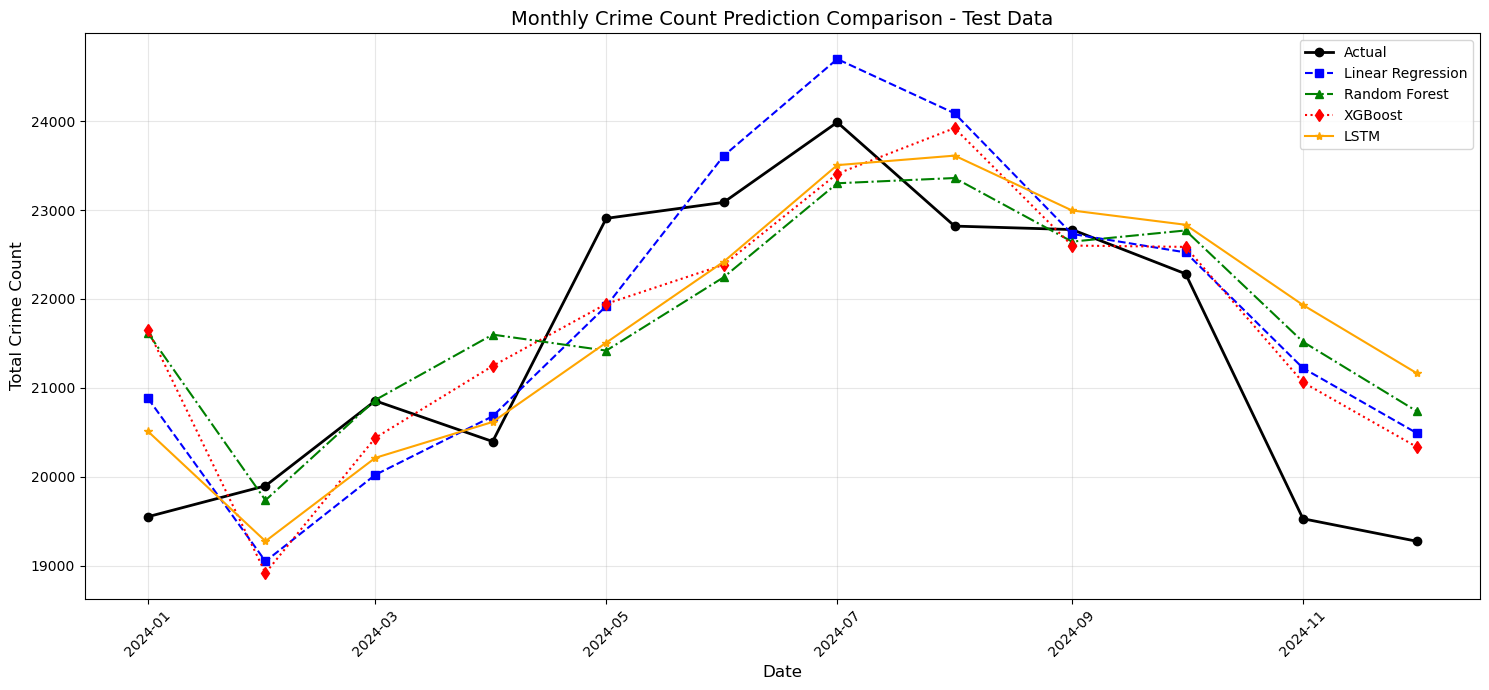

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. MONTHLY AGGREGATION PLOTS
# ============================

# Aggregate by month
monthly_train = (
    df_train_result.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "rf_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
        }
    )
    .reset_index()
)

monthly_test = (
    df_test_result.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "rf_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
        }
    )
    .reset_index()
)

# Create date columns
monthly_train["date"] = pd.to_datetime(
    monthly_train["Year"].astype(str) + "-" + monthly_train["Month"].astype(str) + "-01"
)
monthly_test["date"] = pd.to_datetime(
    monthly_test["Year"].astype(str) + "-" + monthly_test["Month"].astype(str) + "-01"
)

# Sort by date
monthly_train = monthly_train.sort_values("date")
monthly_test = monthly_test.sort_values("date")

y_test_monthly = monthly_test["crime_count"]
# Plot monthly comparison - Training data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_train["date"],
    monthly_train["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_train["date"],
    monthly_train["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_train["date"],
    monthly_train["rf_pred"],
    marker="^",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    monthly_train["date"],
    monthly_train["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.plot(
    monthly_train["date"],
    monthly_train["lstm_pred"],
    marker="*",
    linestyle="-",
    label="LSTM",
    color="orange",
)
plt.title("Monthly Crime Count Prediction Comparison - Training Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_train_data.pdf", format="pdf")
plt.show()

# Plot monthly comparison - Test data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_test["date"],
    monthly_test["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
plt.plot(
    monthly_test["date"],
    monthly_test["rf_pred"],
    marker="^",
    linestyle="-.",
    label="Random Forest",
    color="green",
)
plt.plot(
    monthly_test["date"],
    monthly_test["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lstm_pred"],
    marker="*",
    linestyle="-",
    label="LSTM",
    color="orange",
)
plt.title("Monthly Crime Count Prediction Comparison - Test Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_comparison_test_data.pdf", format="pdf")
plt.show()

In [82]:
for m in ["lr", "rf", "xg", "lstm"]:
    rmse, mae, r2, mae_percentage = summarize_results(monthly_test, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

Model: lr
RMSE	R²	MAE	MAE Percentage
959.44	0.65	832.50	3.88%


Model: rf
RMSE	R²	MAE	MAE Percentage
1146.94	0.50	922.92	4.30%


Model: xg
RMSE	R²	MAE	MAE Percentage
1034.53	0.59	897.75	4.19%


Model: lstm
RMSE	R²	MAE	MAE Percentage
1108.48	0.53	904.08	4.22%




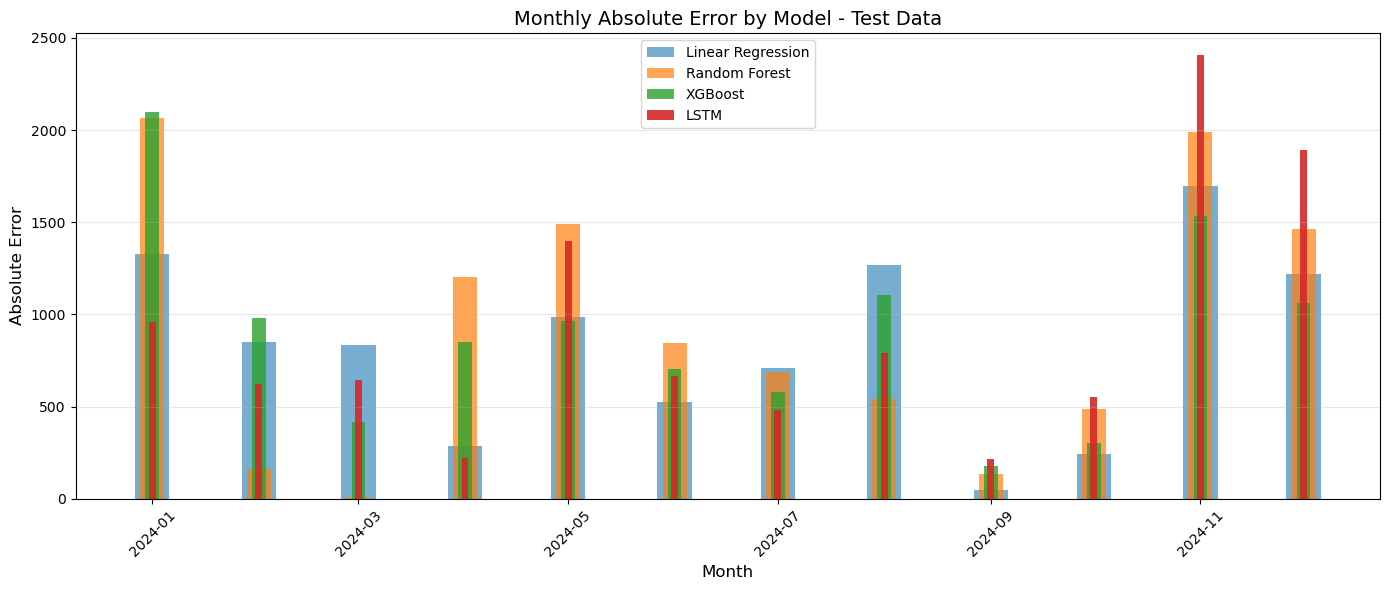

In [83]:
# 2. MODEL PERFORMANCE BY MONTH
# ============================

# Calculate monthly MAE for each model (test data)
monthly_test["lr_mae"] = abs(monthly_test["crime_count"] - monthly_test["lr_pred"])
monthly_test["rf_mae"] = abs(monthly_test["crime_count"] - monthly_test["rf_pred"])
monthly_test["xg_mae"] = abs(monthly_test["crime_count"] - monthly_test["xg_pred"])
monthly_test["lstm_mae"] = abs(monthly_test["crime_count"] - monthly_test["lstm_pred"])

# Plot MAE by month
plt.figure(figsize=(14, 6))
plt.bar(
    monthly_test["date"],
    monthly_test["lr_mae"],
    width=10,
    alpha=0.6,
    label="Linear Regression",
)
plt.bar(
    monthly_test["date"],
    monthly_test["rf_mae"],
    width=7,
    alpha=0.7,
    label="Random Forest",
)
plt.bar(
    monthly_test["date"], monthly_test["xg_mae"], width=4, alpha=0.8, label="XGBoost"
)
plt.bar(
    monthly_test["date"],
    monthly_test["lstm_mae"],
    width=2,
    alpha=0.9,
    label="LSTM",
)
plt.title("Monthly Absolute Error by Model - Test Data", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Absolute Error", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./figure/monthly_absolute_error_by_model_test_data.pdf", format="pdf")
plt.show()

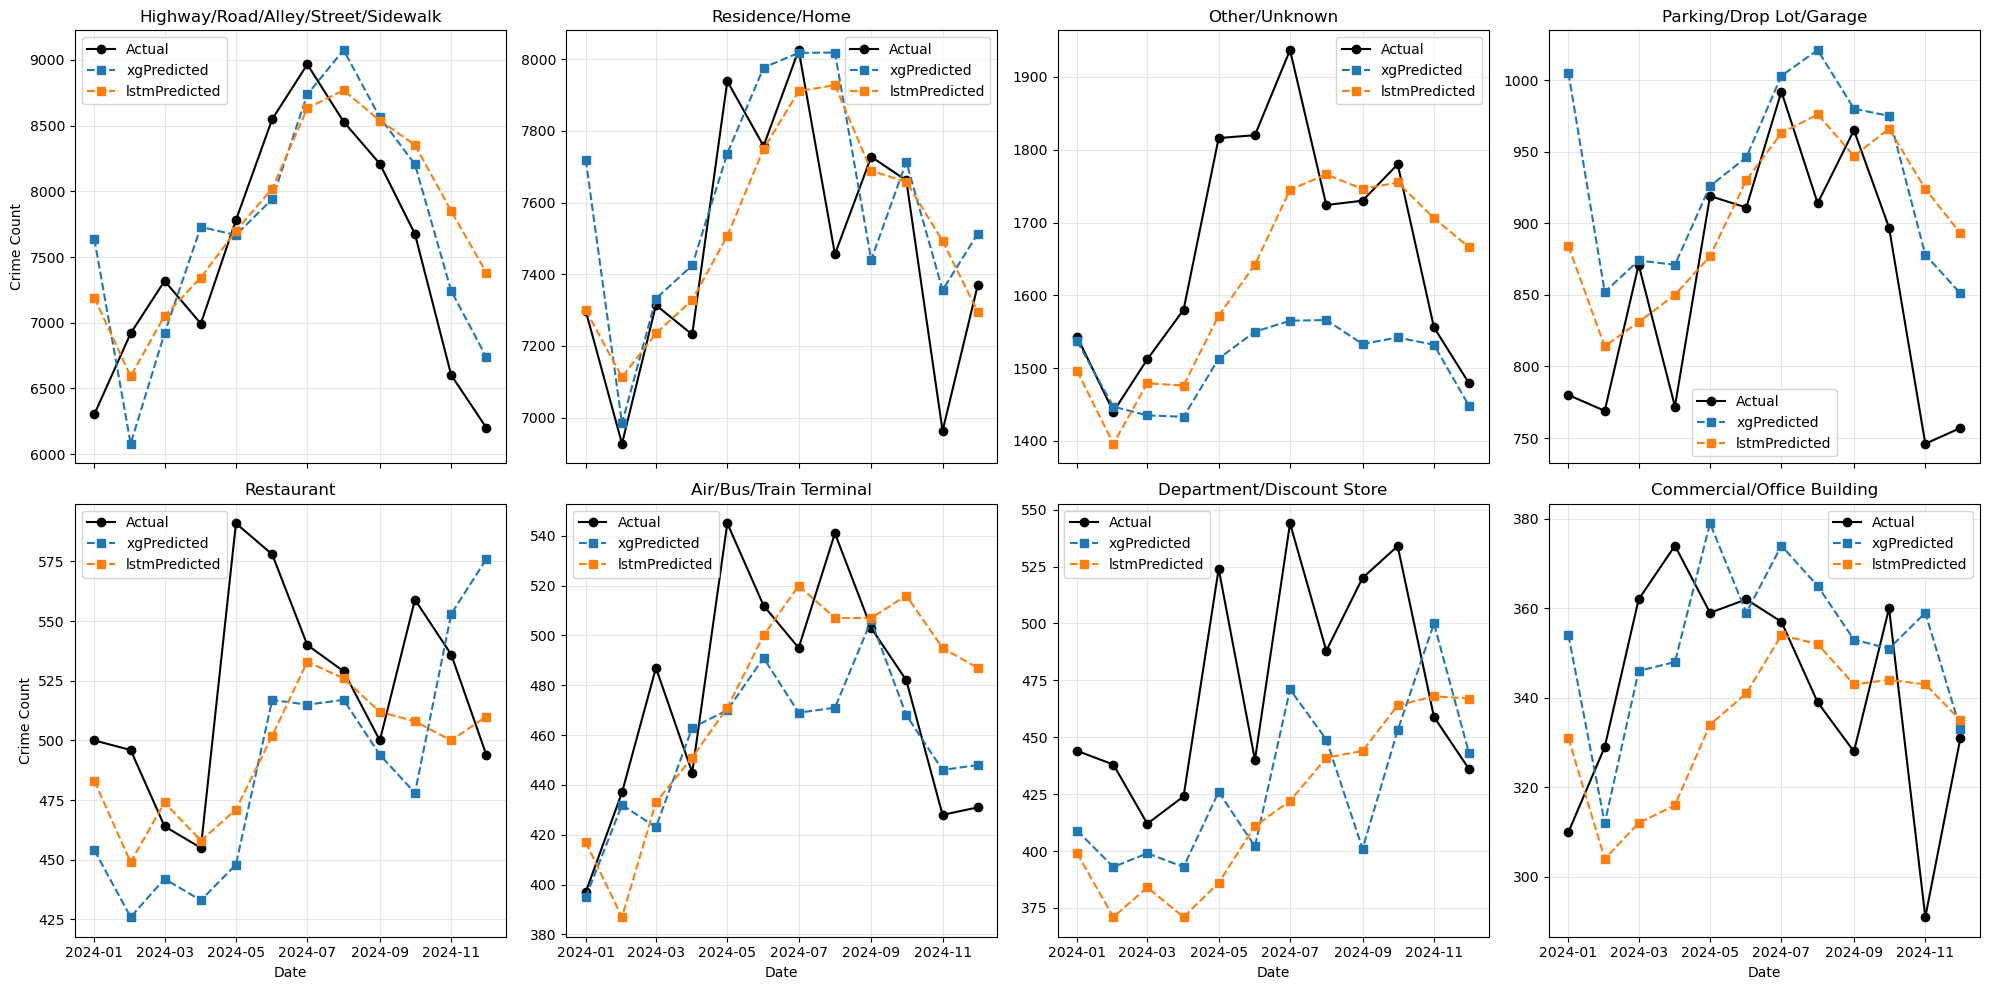

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Identify the top 8 locations by total crime count
top8_locations = (
    df_test_result.groupby("location_name")["crime_count"]
    .sum()
    .nlargest(8)
    .index.tolist()
)

# 2. Filter data for these top 8 locations
df_top8 = df_test_result[df_test_result["location_name"].isin(top8_locations)].copy()

# 3. Aggregate monthly data (summing the actual and predicted counts)
df_trend = df_top8.groupby(["location_name", "Year", "Month"], as_index=False).agg(
    crime_count=("crime_count", "sum"),
    rf_pred=("rf_pred", "sum"),
    xg_pred=("xg_pred", "sum"),
    lr_pred=("lr_pred", "sum"),
    lstm_pred=("lstm_pred", "sum"),
)

# 4. Create a datetime column for proper time series plotting (using the 1st day of each month)
df_trend["Date"] = pd.to_datetime(
    df_trend["Year"].astype(str) + "-" + df_trend["Month"].astype(str) + "-01"
)

# 5. Plotting in subplots (2 rows x 4 columns for 8 subplots) without sharing the y-axis
fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 10), sharex=True
)  # Remove sharey to allow independent y-axis
axes = axes.flatten()  # Flatten to iterate easily

for i, loc in enumerate(top8_locations):
    ax = axes[i]
    df_loc = df_trend[df_trend["location_name"] == loc].sort_values("Date")

    # Plot actual crime count
    ax.plot(
        df_loc["Date"],
        df_loc["crime_count"],
        marker="o",
        linestyle="-",
        label="Actual",
        color="black",
    )
    # Plot predicted crime count
    for m in ["xg", "lstm"]:
        ax.plot(
            df_loc["Date"],
            df_loc[f"{m}_pred"],
            marker="s",
            linestyle="--",
            label=f"{m}Predicted",
        )

    ax.set_title(loc)
    ax.grid(True, alpha=0.3)

    # Set labels for the leftmost and bottom plots only
    if i % 4 == 0:  # Leftmost plots
        ax.set_ylabel("Crime Count")
    if i >= 4:  # Bottom row plots
        ax.set_xlabel("Date")

    ax.legend()

# Remove any unused subplots (if there are fewer than 8, not applicable here)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("./figure/monthly_crime_trends_top8_locations_test_data.pdf", format="pdf")
plt.show()

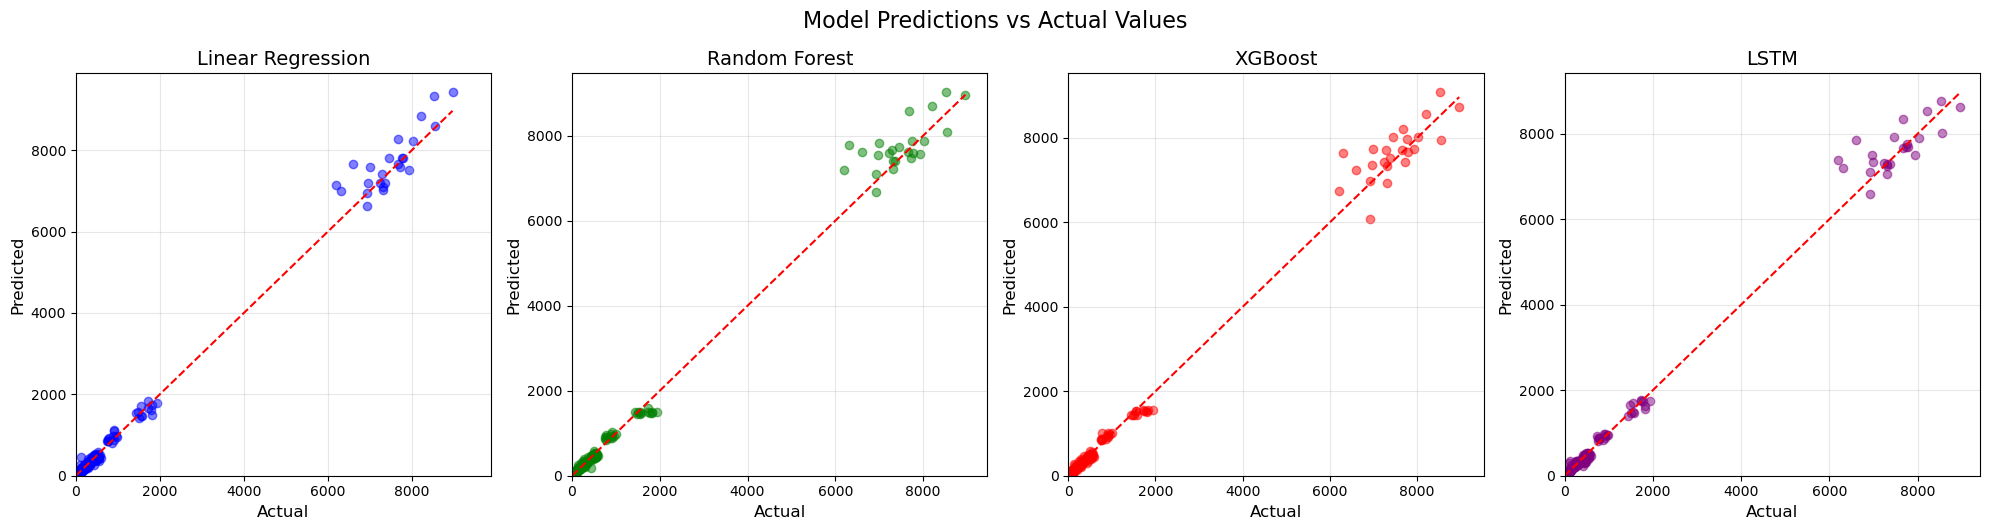

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 4 subplots (for LR, RF, XGBoost, and LSTM)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Define models, colors, and titles
models = ["lr_pred", "rf_pred", "xg_pred", "lstm_pred"]
colors = ["blue", "green", "red", "purple"]
titles = ["Linear Regression", "Random Forest", "XGBoost", "LSTM"]

# Loop through each model and create scatter plot
for i, (model, color, title) in enumerate(zip(models, colors, titles)):
    # Create scatter plot
    axes[i].scatter(
        df_test_result["crime_count"], df_test_result[model], alpha=0.5, color=color
    )

    # Add diagonal line for perfect predictions
    axes[i].plot(
        [0, df_test_result["crime_count"].max()],
        [0, df_test_result["crime_count"].max()],
        "r--",
    )

    # Add title and labels
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("Actual", fontsize=12)
    axes[i].set_ylabel("Predicted", fontsize=12)
    axes[i].grid(True, alpha=0.3)

    # Optional: Set the same limits for all plots for easier comparison
    max_val = max(df_test_result["crime_count"].max(), df_test_result[model].max())
    axes[i].set_xlim(0, max_val * 1.05)
    axes[i].set_ylim(0, max_val * 1.05)

# Adjust layout
plt.tight_layout()
plt.suptitle("Model Predictions vs Actual Values", fontsize=16, y=1.05)
plt.savefig("./figure/model_predictions_vs_actual_values_test_data.pdf", format="pdf")
plt.show()

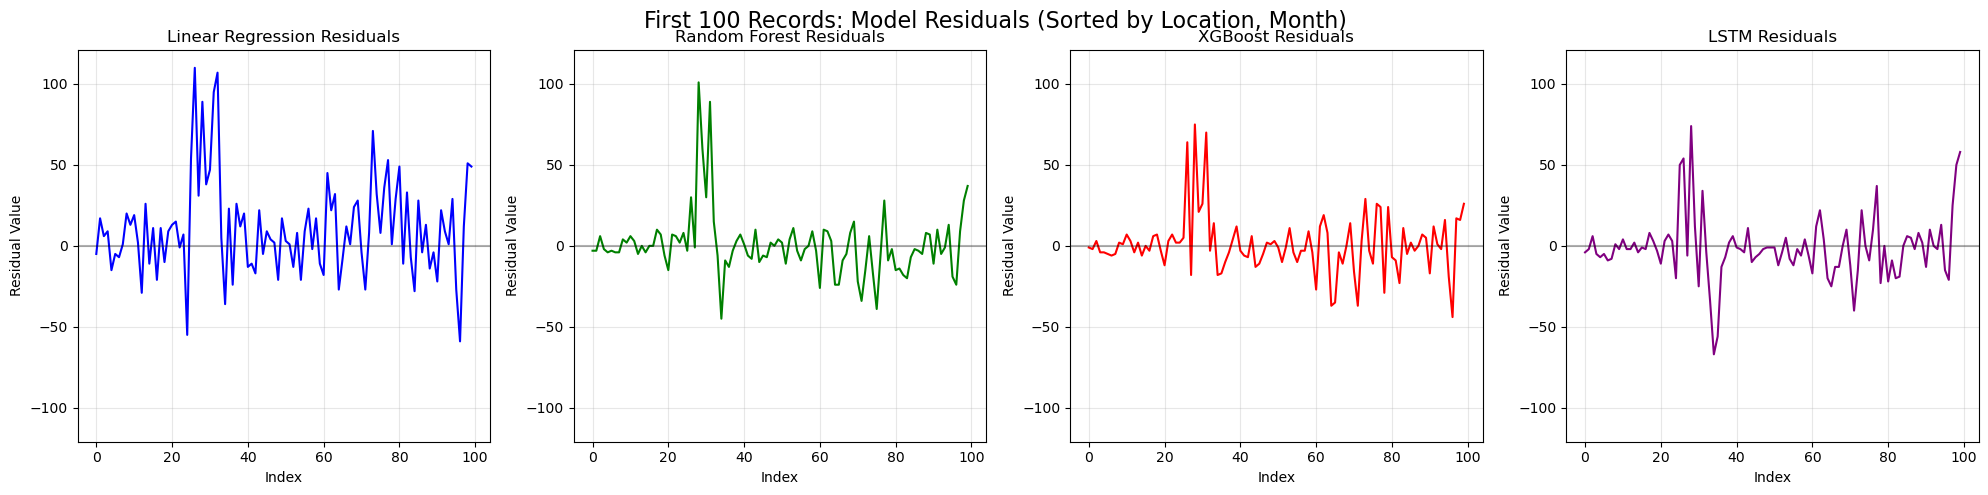

In [86]:
import matplotlib.pyplot as plt

# Create a figure with 4 subplots (for LR, RF, XGBoost, and LSTM)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Sort dataframe by location and time
sorted_df = df_test_result.sort_values(["location_name", "Month"]).reset_index(
    drop=True
)

# Define models, colors, titles, and line styles
models = ["lr_res", "rf_res", "xg_res", "lstm_res"]
colors = ["blue", "green", "red", "purple"]
titles = [
    "Linear Regression Residuals",
    "Random Forest Residuals",
    "XGBoost Residuals",
    "LSTM Residuals",
]
line_styles = ["-", "-", "-", "-"]

# Loop through each model and create residual plot
for i, (model, color, title, ls) in enumerate(zip(models, colors, titles, line_styles)):
    # Plot residuals for first 100 records
    axes[i].plot(
        sorted_df.index[:100],
        sorted_df[model][:100],
        marker="",
        linestyle=ls,
        color=color,
    )

    # Add title and labels
    axes[i].set_title(title)
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("Residual Value")
    axes[i].grid(True, alpha=0.3)

    # Optional: Add a horizontal line at y=0 to show the zero residual line
    axes[i].axhline(y=0, color="black", linestyle="-", alpha=0.3)

    # Optional: Set consistent y-axis limits for all plots
    max_res = max([abs(sorted_df[m][:100]).max() for m in models])
    axes[i].set_ylim(-max_res * 1.1, max_res * 1.1)

# Add a main title to the figure
fig.suptitle(
    "First 100 Records: Model Residuals (Sorted by Location, Month)", fontsize=16
)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for the suptitle
plt.show()